# Analysis of HCP behavioral dataset

Rekha Varrier, main analyses Nov 2020 - Jan 2021.
- Some of the results were presented in an OHBM 2021 poster

Below are the steps to analyse the behavioral data of the HCP social task

In [1]:
#Importing data and packages, creating convenient variables
#%reset
import os
from pathlib import Path
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
%matplotlib inline


folder = os.getcwd()
print('current dir: ',folder)
path = Path(folder)
parent_folder = path.parent
file_loc = os.path.join(parent_folder,'data')
print('data folder:',file_loc)
dataFile  = os.path.join(file_loc,'hcp_social_behav_for_ddm_stim-coding.csv')


current dir:  /Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/BehaviorAnalyses/Documented scripts/code
data folder: /Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/BehaviorAnalyses/Documented scripts/data


In [2]:
file_loc

'/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/BehaviorAnalyses/Documented scripts/data'

In [3]:
# setting default fontsizes for plots

s=16 # CHANGE FONTSIZE HERE

plt.rc('font', size=s) #controls default text size
plt.rc('axes', titlesize=s) #fontsize of the title
plt.rc('axes', labelsize=s) #fontsize of the x and y labels
plt.rc('xtick', labelsize=s) #fontsize of the x tick labels
plt.rc('ytick', labelsize=s) #fontsize of the y tick labels
plt.rc('legend', fontsize=s) #fontsize of the legend
#import matplotlib as mpl
#mpl.rcParams['font.weight']= 'normal'


In [4]:
vid_names = {}
vid_names["run1"] = ["COAXING-B", "BILLIARD-A", "DRIFTING-A", "Fishing", "Random mechanical"]
vid_names["run2"] = ["Scaring", "SEDUCING-B", "STAR-A", "SURPRISING-B", "TENNIS-A"]
vid_joined = ["COAXING-B", "BILLIARD-A", "DRIFTING-A", "Fishing", "Random mechanical","Scaring", "SEDUCING-B", "STAR-A", "SURPRISING-B", "TENNIS-A"]


dat = pd.read_csv(dataFile)# , index_col = "subj_idx")
dat["run"] = ["run2" if x.split('.')[0] in vid_names["run1"] else "run1" for x in dat["movie"]]
dat["run"] = [0 if x.split('.')[0] in vid_names["run1"] else 1 for x in dat["movie"]]

print("n=",len(np.unique(dat["subj_idx"])))
dat.head(10)

n= 1051


,subj_idx,stim,movie,rt,response,run
0,168745,Mental,Scaring.AVI,1.252,1,1
1,168745,Mental,SEDUCING-B.AVI,0.578,1,1
2,168745,Random,STAR-A.AVI,1.643,0,1
3,168745,Mental,SURPRISING-B.AVI,1.082,1,1
4,168745,Random,TENNIS-A.AVI,1.232,0,1
5,668361,Mental,COAXING-B.AVI,1.796,9,0
6,668361,Random,BILLIARD-A.AVI,1.254,0,0
7,668361,Random,DRIFTING-A.AVI,0.590,0,0
8,668361,Mental,Fishing.AVI,0.993,0,0
9,668361,Random,Random mechanical.AVI,0.816,0,0


In [5]:
# exclude bad subjects (with <10 yes/no/unsure responses)

thresh = 10
trial_counts = dat.groupby("subj_idx").count()["rt"]
bad_subs = trial_counts[(trial_counts < thresh)].index
#print(bad_subs)
dat  = dat.reset_index() # add index as an additional column "index"
dat = dat.set_index('subj_idx') # make subj_idx the index
dat.drop(bad_subs, inplace=True) # remove bad subjects
dat = dat.reset_index() #bring back subj_idx as a column
dat = dat.set_index('index') # make the column "index" as the index (as in the beginning)

print("Nr. of subjects left",len(dat.groupby("subj_idx")))
print("Nr. of rows:",dat.shape)

Nr. of subjects left 826
Nr. of rows: (8260, 6)


In [6]:
#add accuracy as an additional column, remove impossible RTs

# add accuracy
acc = np.zeros((dat.shape[0],)) -1 # initialize accuracy with -1
acc[((dat['stim'] == 'Mental') & (dat['response'] == 1)) | ((dat['stim'] == 'Random') & (dat['response'] == 0))] = 1
acc[((dat['stim'] == 'Mental') & (dat['response'] == 0)) | ((dat['stim'] == 'Random') & (dat['response'] == 1))] = 0
acc[dat['response'] == 9] = 9
dat['accuracy'] = acc

# remove imppossible RTs
rtmin = 0.1 # threshold for impossibly short RTs
print('nrows before=',dat.shape[0])
dat= dat.loc[dat['rt']>=rtmin,:]
print('nrows after=',dat.shape[0])
#dat.head()


nrows before= 8260
nrows after= 8257


In [6]:
#red_rgb = [103,0,31] # edges of RdBu
#blue_rgb = [5,48,97] # edges of RdBu
red_rgb =[188,61,62] # from Emily
blue_rgb = [54,122,177] # from Emily
red_rgb = np.array(red_rgb)/255
blue_rgb = np.array(blue_rgb)/255
alpha = .2 # transparency inside boxplots, for datapts etc.

In [7]:
dat.to_csv(os.path.join(file_loc,'data_for_paper','hcp_social_826subs.csv'))

In [8]:
#Sort into sure and unsure trials dfs
data_sure = dat[dat["response"]!=9]
data_unsure = dat[dat["response"] ==9]
len(np.unique(data_sure['subj_idx']))

826

In [9]:
#excluding bad subs: defined as those who have less than 'thresh' trials
# defined as 8/10 responses "sure", i.e., yes/no
# did this to make sure we have a good number of trials/subject - since our main analyses were only on the 
# sure trials

'''thresh = 8
trial_counts = data_sure.groupby("subj_idx").count()["rt"]
bad_subs = trial_counts[(trial_counts < thresh)].index
#print(bad_subs)
data_sure  = data_sure.reset_index() # add index as an additional column "index"
data_sure = data_sure.set_index('subj_idx') # make subj_idx the index
data_sure.drop(bad_subs, inplace=True) # remove bad subjects
data_sure = data_sure.reset_index() #bring back subj_idx as a column
data_sure = data_sure.set_index('index') # make the column "index" as the index (as in the beginning)

print("Nr. of subjects left",len(data_sure.groupby("subj_idx")))
print("Nr. of rows:",data_sure.shape)'''

'thresh = 8\ntrial_counts = data_sure.groupby("subj_idx").count()["rt"]\nbad_subs = trial_counts[(trial_counts < thresh)].index\n#print(bad_subs)\ndata_sure  = data_sure.reset_index() # add index as an additional column "index"\ndata_sure = data_sure.set_index(\'subj_idx\') # make subj_idx the index\ndata_sure.drop(bad_subs, inplace=True) # remove bad subjects\ndata_sure = data_sure.reset_index() #bring back subj_idx as a column\ndata_sure = data_sure.set_index(\'index\') # make the column "index" as the index (as in the beginning)\n\nprint("Nr. of subjects left",len(data_sure.groupby("subj_idx")))\nprint("Nr. of rows:",data_sure.shape)'

# 1(a) Number of responses per movie

In [10]:
movies_list = list(dat['movie'].values)
print(movies_list[:5])
dat['movies_ind']=[np.where(vid_joined==np.array(i[:-4]))[0][0] for i in movies_list]
dat

['Scaring.AVI', 'SEDUCING-B.AVI', 'STAR-A.AVI', 'SURPRISING-B.AVI', 'TENNIS-A.AVI']


,subj_idx,stim,movie,rt,response,run,accuracy,movies_ind
index,,,,,,,,
0,168745,Mental,Scaring.AVI,1.252,1,1,1.0,5
1,168745,Mental,SEDUCING-B.AVI,0.578,1,1,1.0,6
2,168745,Random,STAR-A.AVI,1.643,0,1,1.0,7
3,168745,Mental,SURPRISING-B.AVI,1.082,1,1,1.0,8
4,168745,Random,TENNIS-A.AVI,1.232,0,1,1.0,9
...,...,...,...,...,...,...,...,...
10144,175136,Mental,COAXING-B.AVI,1.542,1,0,1.0,0
10145,175136,Random,BILLIARD-A.AVI,0.893,0,0,1.0,1
10146,175136,Random,DRIFTING-A.AVI,0.895,0,0,1.0,2


In [16]:
counts = dat.groupby(['movies_ind','response']).count().subj_idx.unstack(level=-1)
counts[np.isnan(counts)] = 0
counts['sum'] = counts[0]+counts[1]+counts[9]
#counts = counts.sort_values(by=['movies_ind','response'])
#counts = counts.append({'movies_ind':8,'response':0,'subj_idx':0},ignore_index=True)
counts['socialness'] = counts[1]/counts['sum']
socialness = counts['socialness'].values
counts =  counts.sort_values(by=['socialness'])
counts

response,0,1,9,sum,socialness
movies_ind,,,,,
2,782.0,6.0,38.0,826.0,0.007264
1,780.0,11.0,34.0,825.0,0.013333
7,761.0,20.0,45.0,826.0,0.024213
9,694.0,35.0,97.0,826.0,0.042373
4,564.0,86.0,176.0,826.0,0.104116
3,58.0,701.0,67.0,826.0,0.848668
5,24.0,783.0,19.0,826.0,0.947942
6,5.0,805.0,16.0,826.0,0.974576
0,7.0,811.0,6.0,824.0,0.984223


In [17]:
socialness

array([0.9842233 , 0.01333333, 0.00726392, 0.84866828, 0.10411622,
       0.94794189, 0.97457627, 0.02421308, 0.99636804, 0.04237288])

In [18]:
np.save(os.path.join(file_loc,'hcp_socialness.npy'),socialness)

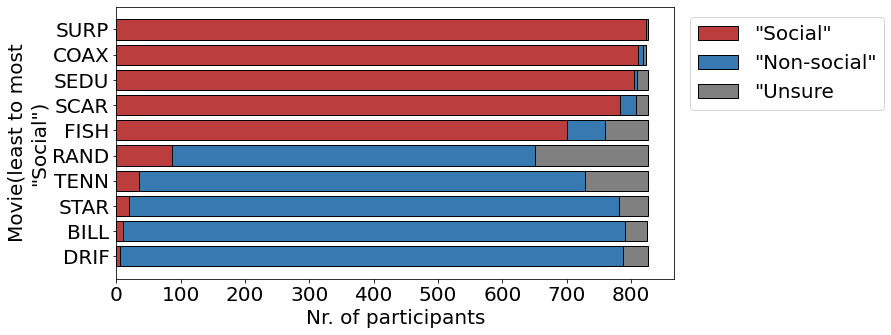

In [194]:
def plot_fig_1a(ax):
    ax.barh(range(10),counts[1],color=red_rgb,label='"Social"',edgecolor='k')
    ax.barh(range(10),counts[0],left=counts[1],edgecolor='k',color=blue_rgb,label='"Non-social"')
    ax.barh(range(10),counts[9],left=counts[0]+counts[1],color='grey',edgecolor='k',label='"Unsure')

    ax.legend(bbox_to_anchor=[1.01,1])
    ax.set_yticks(range(10))
    ax.set_yticklabels([str.upper(vid_joined[i][:4]) for i in counts.index])
    ax.set_xlabel('Nr. of participants')
    ax.set_ylabel('Movie(least to most\n"Social")')

fig = plt.figure(1,figsize=(10,5))
ax =  fig.add_subplot(111)
plot_fig_1a(ax)


### 1(b) Number of yes/no responses per sub (for paper)

- to evaluate if there are more Yes responses than No responses on average - suggesting a Yes bias

In [51]:
counts_per_subj = data_sure.groupby(['subj_idx', 'response']).count().movie # Mean count per subject for Mental and Random
counts_per_subj = counts_per_subj.unstack(level = -1)
counts_per_subj['diff'] = counts_per_subj[1]-counts_per_subj[0]
counts_per_subj['sum'] = counts_per_subj[1]+counts_per_subj[0]
counts_per_subj


response,0,1,diff,sum
subj_idx,,,,
100206,1.0,9.0,8.0,10.0
100307,4.0,5.0,1.0,9.0
100408,4.0,5.0,1.0,9.0
100610,5.0,5.0,0.0,10.0
101309,2.0,5.0,3.0,7.0
...,...,...,...,...
991267,4.0,5.0,1.0,9.0
992673,5.0,5.0,0.0,10.0
992774,4.0,5.0,1.0,9.0


In [52]:
# exclude subs with 0 responses in social/nonsocial and subjs with fewer than 8 yes/no responses
rows = ~np.isnan(counts_per_subj['diff'])
counts_per_subj = counts_per_subj.loc[rows,:]
counts_per_subj.shape

(824, 4)

In [53]:
# compute response perceptages and theur diiference
counts_per_subj.loc[:,'No_pc']  = 100*counts_per_subj.loc[:,0]/counts_per_subj.loc[:,'sum']
counts_per_subj.loc[:,'Yes_pc'] = 100*counts_per_subj.loc[:,1]/counts_per_subj.loc[:,'sum']
counts_per_subj.loc[:,'Soc-NonSoc_pc'] = counts_per_subj.loc[:,'Yes_pc'] - counts_per_subj.loc[:,'No_pc']
counts_per_subj

/Users/f0053cz/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/f0053cz/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/indexing.py:1783: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


response,0,1,diff,sum,No_pc,Yes_pc,Soc-NonSoc_pc
subj_idx,,,,,,,
100206,1.0,9.0,8.0,10.0,10.000000,90.000000,80.000000
100307,4.0,5.0,1.0,9.0,44.444444,55.555556,11.111111
100408,4.0,5.0,1.0,9.0,44.444444,55.555556,11.111111
100610,5.0,5.0,0.0,10.0,50.000000,50.000000,0.000000
101309,2.0,5.0,3.0,7.0,28.571429,71.428571,42.857143
...,...,...,...,...,...,...,...
991267,4.0,5.0,1.0,9.0,44.444444,55.555556,11.111111
992673,5.0,5.0,0.0,10.0,50.000000,50.000000,0.000000
992774,4.0,5.0,1.0,9.0,44.444444,55.555556,11.111111


Ttest_1sampResult(statistic=10.009446633489986, pvalue=2.466374395919296e-22)

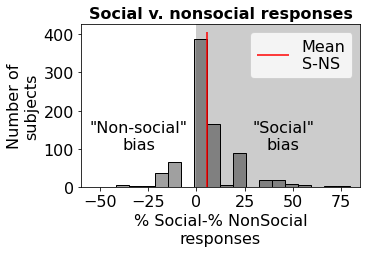

In [66]:
fig = plt.figure(1,figsize=(5,3))
ax = fig.add_subplot(111)
sns.histplot(data=counts_per_subj,bins=20,x='Soc-NonSoc_pc',color='grey')
ax.set_xlabel('% Social-% NonSocial\nresponses')
ax.set_ylabel('Number of\nsubjects')
ymin,ymax = ax.get_ylim()
ax.vlines(counts_per_subj.mean()['Soc-NonSoc_pc'],ymin,ymax,color = 'r',label = 'Mean\nS-NS')
ax.set_xticks([-75,-50,-25,0,25,50,75])
ax.legend(loc='upper right')
ax.set_xlim(-60,85)
xmin,xmax = ax.get_ylim()
ax.axvspan(0,xmax, facecolor= '0', alpha=0.2) # background color for the first 5 bars(mental?)
ax.axvspan(xmin,0, facecolor='0.1', alpha=0.2) # background color for the first 5 bars(mental?)

ax.text(-30,100,'"Non-social"\nbias', ha='center', color = 'black')
ax.text(45,100,'"Social"\nbias', ha='center', color = 'black')
ax.set_title("Social v. nonsocial responses",fontweight='bold')

stats.ttest_1samp(counts_per_subj['Soc-NonSoc_pc'], 0)





In [55]:
print(f"25%:{np.quantile(counts_per_subj['Yes_pc'],.25):.2f}, 50%:{np.quantile(counts_per_subj['Yes_pc'],.5):.2f}, 75%:{np.quantile(counts_per_subj['Yes_pc'],.75):.2f}")
print(f"25%:{np.quantile(counts_per_subj['No_pc'],.25):.2f}, 50%:{np.quantile(counts_per_subj['No_pc'],.5):.2f}, 75%:{np.quantile(counts_per_subj['No_pc'],.75)}")


25%:50.00, 50%:50.00, 75%:55.56
25%:44.44, 50%:50.00, 75%:50.0


In [56]:
def box_plot(data, edge_color, fill_color,pos,v):
    # customize boxplots
    alpha= .2
    bp = ax.boxplot(data, positions = [pos], patch_artist=True,widths=.5,vert=v,flierprops = dict(markeredgecolor=edge_color,
    markerfacecolor=fill_color, alpha=alpha))
    
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'caps']:
        plt.setp(bp[element], color=edge_color)
    for element in ['medians']:
        plt.setp(bp[element], color='k',linewidth=2,ls='dashed')

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color,alpha=alpha)#'w'       
        
    return bp

In [57]:
# exploring colors 
import matplotlib.cm
for i in range(len(matplotlib.cm.datad["RdBu"])):
    print(np.array(matplotlib.cm.datad["RdBu"][i])*255)
#red_rgb = np.array(matplotlib.cm.datad["RdBu"][0])*255
#blue_rgb = np.array(matplotlib.cm.datad["RdBu"][-1])*255
#print('red:',red_rgb,',\n blue:',blue_rgb)


[103.   0.  31.]
[178.  24.  43.]
[214.  96.  77.]
[244. 165. 130.]
[253. 219. 199.]
[247. 247. 247.]
[209. 229. 240.]
[146. 197. 222.]
[ 67. 147. 195.]
[ 33. 102. 172.]
[ 5. 48. 97.]


mean diff: 5.602076591154261


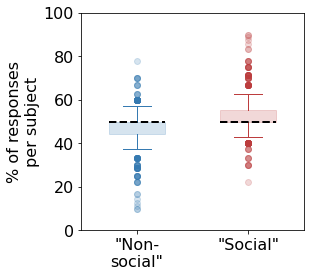

In [151]:
def plot_fig_1b(ax):
        
    #plt.boxplot([counts_per_subj['Yes_pc'],counts_per_subj['No_pc']],positions = [1,0],widths =.8, color='r')
    #ax.boxplot(counts_per_subj['Yes_pc'], positions = [0], patch_artist=True)
    bp1 = box_plot(counts_per_subj['Yes_pc'], red_rgb, red_rgb,1,True)
    bp2 = box_plot(counts_per_subj['No_pc'], blue_rgb, blue_rgb,0,True)
    #ax.set_ylim(0, 10)

    #plt.axhspan(0,50, facecolor= '0.5', alpha=0.2) # background color for the first 5 bars(mental?)
    #sns.barplot(data=counts_per_subj.loc[:,['No_pc','Yes_pc']].melt(),x='response',y='value',edgecolor = 'k',alpha=.5)
    plt.xticks(range(2),['"Non-\nsocial"','"Social"'])
    plt.ylabel("% of responses\nper subject")
    plt.ylim(0,100)
    xmin,xmax = plt.xlim()
    plt.xlabel('')

    print('mean diff:',np.nanmean(counts_per_subj['Yes_pc']-counts_per_subj['No_pc']))
    stats.ttest_rel(counts_per_subj['No_pc'],counts_per_subj['Yes_pc'])

fig = plt.figure(figsize=(4,4))
ax =  fig.add_subplot(111)
plot_fig_1b(ax)

In [152]:
# save data for trait analysis etc
counts_per_subj = counts_per_subj.rename(columns={0: 'countNonSoc(No)', 1: 'countSoc(Yes)','diff':'Yes-No','sum':'Yes+No'})
counts_per_subj

response,countNonSoc(No),countSoc(Yes),Yes-No,Yes+No,No_pc,Yes_pc,Soc-NonSoc_pc
subj_idx,,,,,,,
100206,1.0,9.0,8.0,10.0,10.000000,90.000000,80.000000
100307,4.0,5.0,1.0,9.0,44.444444,55.555556,11.111111
100408,4.0,5.0,1.0,9.0,44.444444,55.555556,11.111111
100610,5.0,5.0,0.0,10.0,50.000000,50.000000,0.000000
101309,2.0,5.0,3.0,7.0,28.571429,71.428571,42.857143
...,...,...,...,...,...,...,...
991267,4.0,5.0,1.0,9.0,44.444444,55.555556,11.111111
992673,5.0,5.0,0.0,10.0,50.000000,50.000000,0.000000
992774,4.0,5.0,1.0,9.0,44.444444,55.555556,11.111111


In [131]:
counts_per_subj.to_csv(os.path.join(file_loc,'data_for_paper','1b_S_NS_responses_per_subj.csv'))

## 2. SDT estimates for our data

- in addition to counting one or the other responses, we can also use signal detection measures to see how they align with experimenter-assigned labels. For example, a higher number of "social" responses could show in a net(1) response bias towards social, and/or (2) an decrease in d prime (?)

In [132]:
# Function to compute SDT measures like dprime, critia etc. 
from scipy.stats import norm
import math
Z = norm.ppf
 
def SDT(hits, misses, fas, crs):
    """ returns a dict with d-prime measures given hits, misses, false alarms, and correct rejections"""
    # Floors an ceilings are replaced by half hits and half FA's
    half_hit = 0.5 / (hits + misses)
    half_fa = 0.5 / (fas + crs)
 
    # Calculate hit_rate and avoid d' infinity
    hit_rate = hits / (hits + misses)
    if hit_rate == 1: 
        hit_rate = 1 - half_hit
    if hit_rate == 0: 
        hit_rate = half_hit
 
    # Calculate false alarm rate and avoid d' infinity
    fa_rate = fas / (fas + crs)
    if fa_rate == 1: 
        fa_rate = 1 - half_fa
    if fa_rate == 0: 
        fa_rate = half_fa
 
    # Return d', beta, c and Ad'
    out = {}
    out['d'] = Z(hit_rate) - Z(fa_rate)
    out['beta'] = math.exp((Z(fa_rate)**2 - Z(hit_rate)**2) / 2)
    out['c'] = -(Z(hit_rate) + Z(fa_rate)) / 2
    out['Ad'] = norm.cdf(out['d'] / math.sqrt(2))
    
    return(out)

In [133]:
#creating a matrix of hits, FAs, FNs and CRs per subject

matrix = data_sure.groupby(["subj_idx", "stim"])["response"].value_counts().unstack().fillna(0) #/n_trials
matrix.head(10)

hits = matrix[matrix.index.get_level_values("stim")=="Mental"].reset_index("stim")[1] # '1' responses for Mental
misses = matrix[matrix.index.get_level_values("stim")=="Mental"].reset_index("stim")[0] # '0' responses for Mental
false_alarms = matrix[matrix.index.get_level_values("stim")=="Random"].reset_index("stim")[1]
correct_rejects = matrix[matrix.index.get_level_values("stim")=="Random"].reset_index("stim")[0]

hits.name='hits'
misses.name='misses'
false_alarms.name='false_alarms'
correct_rejects.name='correct_rejects'

sdt_data = pd.concat([hits, misses, false_alarms, correct_rejects], axis=1)
sdt_data.head()

#sdt_data.transpose().plot(legend = None, alpha = 0.1)

,hits,misses,false_alarms,correct_rejects
subj_idx,,,,
100206,5.0,0.0,4.0,1.0
100307,4.0,0.0,1.0,4.0
100408,5.0,0.0,0.0,4.0
100610,5.0,0.0,0.0,5.0
101309,5.0,0.0,0.0,2.0


In [134]:
#invoke the SDT functions + sample results for subj1
s = 0
SDT(sdt_data["hits"].iloc[s], sdt_data["misses"].iloc[s], sdt_data["false_alarms"].iloc[s], sdt_data["correct_rejects"].iloc[s])

{'d': 0.4399303319716861,
 'beta': 0.6268650096300457,
 'c': -1.0615863995587573,
 'Ad': 0.622129231220526}

In [70]:
# extracting SDT measures for each subject and saving in a dataframe
results = {}
for s, subj in enumerate(sdt_data.index.values):
    results[subj] = SDT(sdt_data["hits"].iloc[s], sdt_data["misses"].iloc[s], sdt_data["false_alarms"].iloc[s], sdt_data["correct_rejects"].iloc[s])

sdt_measures = pd.DataFrame.from_dict(results, orient="index")
sdt_measures.head()

,d,beta,c,Ad
100206,0.439930,0.626865,-1.061586,0.622129
100307,1.991971,0.735291,-0.154364,0.920514
100408,2.431901,0.852540,-0.065601,0.957249
100610,2.563103,1.000000,-0.000000,0.965037
101309,1.956041,0.552270,-0.303531,0.916688


341551.0 , 2.2423052314575717e-140


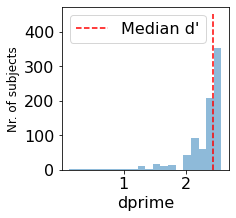

In [72]:
# Plotting the distributions of dprimes and criteria across subjects
# second figure used in the OHBM poster and paper  (1b)
plt.figure(1,figsize =(3,3))
sdt_measures['d'].hist(bins=20, alpha = 0.5)
plt.plot(np.zeros((10,1))+np.median(sdt_measures['d']), np.arange(0,500,50), 'r', linestyle = 'dashed',label = "Median d'")
plt.grid(None)
plt.ylabel('Nr. of subjects', fontsize = 12)
plt.xlabel("dprime")
plt.legend()

std,pdprime = stats.wilcoxon(sdt_measures['d'], alternative = 'greater') # non parametric alternative to one-sample ttest
print(std,',',pdprime)


27043.0 , 5.418474953624208e-19


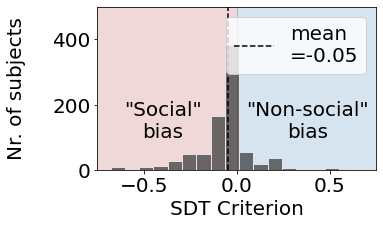

In [174]:
def plot_fig_1c(ax):

    #plt.title('Response bias', fontweight = 'bold')
    ax.axvspan(-1,0,color=red_rgb,alpha=alpha)
    ax.axvspan(0,1,color=blue_rgb,alpha=alpha)
    #sns.distplot(sdt_measures['c'], bins= 30, label = 'criterion bias across subjects', norm_hist = False)
    sdt_measures['c'].hist(bins=25, alpha = .7, color = [.2,.2,.2],edgecolor = 'white')
    #plt.vlines(np.nanmean(sdt_measures['c']),0,500,color='r', linewidth = 3,linestyle = 'solid',
    #           label = f'mean={np.round(np.nanmean(sdt_measures["c"]),2)},\np(Wilc.)=\n{1.9e-26}')
    ax.vlines(np.nanmean(sdt_measures['c']),0,500,color='k', linestyle = 'dashed',
            label = f'mean\n={np.round(np.nanmean(sdt_measures["c"]),2)}')

            #plt.plot(np.zeros((10,1)), np.linspace(0,450,10),\
    #         'grey', linestyle = 'dashed',label = f'0(No bias)')

    ax.grid(None)
    ax.set_ylabel('Nr. of subjects\n ')
    ax.set_xlabel("SDT Criterion")
    ax.set_xlim(-.75,.75)
    ax.set_ylim(0,500)
    #plt.xticks([-.75,-.5,-.25,0,.25,.5,.75], rotation=30)
    #plt.legend(fontsize = 14,bbox_to_anchor=(1.02, 1), loc='upper left')
    ax.legend()#bbox_to_anchor = (1.05,1))

    ax.text(-.4,100,'"Social"\nbias', ha='center',  color = 'k')
    ax.text(.38,100,'"Non-social"\nbias', ha='center', color = 'k')

    #plt.legend(handles=[p1, p2], title='title', bbox_to_anchor=(1.05, 1), loc='upper left', prop=fontP)
    stc, pc = stats.wilcoxon(sdt_measures['c'])
    print(stc,',',pc)

fig = plt.figure(1,figsize=(5,3))
ax = fig.add_subplot(111)
plot_fig_1c(ax)


In [135]:
# save data for trait analysis etc
sdt_measures.to_csv(os.path.join(file_loc,'data_for_paper','1c_SDTmeasures_per_subj.csv'))

Text(0, 0.5, 'criterion per subject')

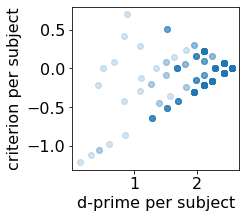

In [78]:
#dprime vs. criterion
plt.figure(1,figsize =(3,3))
plt.scatter(sdt_measures['d'],sdt_measures['c'],alpha = .2)
stats.spearmanr(sdt_measures['d'],sdt_measures['c'])
plt.xlabel('d-prime per subject')
plt.ylabel('criterion per subject')



# LMEs

In [79]:
# LME:

# We use the Python version called pymer4 of the R package lme4.

#from pymer4.test_install import test_install; test_install() # to test pyme4r install
# important: pymer installed in the conda environment py37 (python v3.7x), 
# so if module can't be found here, quit Jupyter and type 'conda activate py37' into terminal

#install lme functions
from pymer4.models import Lmer
#from pymer4.models import Lm

- Subject and stimulus being random factors that could've influenced results, it's important to control for them. LMEM lets us control for their effects on the DV using random intercepts and sometimes also on how the regressors affect the DV (using random slopes). The following cells show various LMEMs.

Interpreting the logistic regression results : if coef= .379
log(p(r=1)/p(r=0)) = .379 So p(r=1)/p(r=0) = exp(.379) > 1, so p(r=1) is more likely, BUT p-value = 0.749 so results are not significant.

## Reaction time

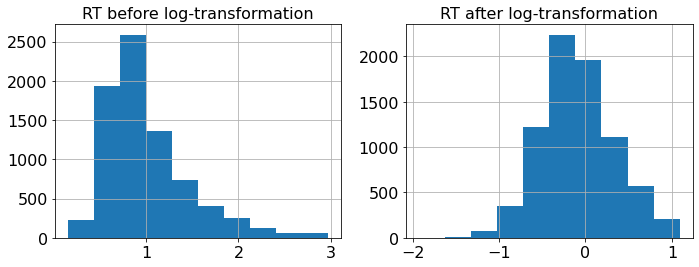

In [80]:
#log-transforming RT makes the distribution closer to a Gaussian
data_sure = data_sure.assign(logRT = np.log(data_sure['rt'])) # add a column for logRT
data_sure.head()

plt.figure(1, figsize=(10,4))
plt.subplot(1,2,1)
plt.title("RT before log-transformation")
data_sure['rt'].hist()
plt.subplot(1,2,2)
plt.title("RT after log-transformation")
data_sure['logRT'].hist()
plt.tight_layout()

- Most of the analyses will be done on the sure responses.
- RT is skewed and hence we take its log-transform (still not fully normal)

<font color=red> TODO sometime: Look for the best family of distribution for RT (better than log) potentially using KL divergence, shift to glmer function and perhaps R </font>

## Qn: Are "social" responses faster than "nonsocial" responses?

response,0,1,diff
subj_idx,,,
100206,0.6830,0.764,0.0810
100307,0.5925,0.542,-0.0505
100408,1.2675,1.286,0.0185
100610,0.8480,1.267,0.4190
101309,1.3965,0.843,-0.5535
...,...,...,...
991267,0.9875,0.759,-0.2285
992673,1.3870,1.096,-0.2910
992774,0.5130,0.560,0.0470


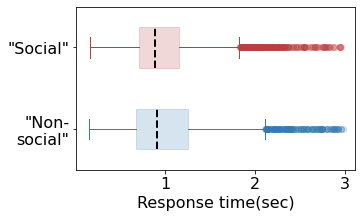

In [146]:
def plot_fig_1d(ax):

    #rt_per_resptype_mean = data_sure.groupby(['response']).mean().rt
    #rt_per_resptype_sem = data_sure.groupby(['response']).sem().rt

    #plt.figure(1, figsize=(5,2))
    #plt.boxplot([counts_per_subj['Yes_pc'],counts_per_subj['No_pc']],positions = [1,0],widths =.8, color='r')
    #ax.boxplot(counts_per_subj['Yes_pc'], positions = [0], patch_artist=True)
    bp1 = box_plot(data_sure.loc[data_sure['response']==1,'rt'], red_rgb, red_rgb,1,False)
    bp2 = box_plot(data_sure.loc[data_sure['response']==0,'rt'], blue_rgb, blue_rgb,0,False)

    rts_per_subj = data_sure.groupby(['subj_idx', 'response']).median().rt.unstack(level=-1) # Mean count per subject for Mental and Random
    rts_per_subj['diff'] = rts_per_subj[1]-rts_per_subj[0]
    ax.set_yticks(range(2))
    ax.set_yticklabels(('"Non-\nsocial"','"Social"'))
    ax.set_ylabel('')
    ax.set_xlabel('Response time(sec)')
    
    return rts_per_subj

fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(111)
rts_per_subj = plot_fig_1d(ax)
rts_per_subj


In [105]:
rts_per_subj = rts_per_subj.rename(columns={0: 'medianRT_NonSoc(No)', 1: 'medianRT_Soc(Yes)','diff':'medianYes-medianNo'})
rts_per_subj

response,medianRT_NonSoc(No),medianRT_Soc(Yes),medianYes-medianNo
subj_idx,,,
100206,0.6830,0.764,0.0810
100307,0.5925,0.542,-0.0505
100408,1.2675,1.286,0.0185
100610,0.8480,1.267,0.4190
101309,1.3965,0.843,-0.5535
...,...,...,...
991267,0.9875,0.759,-0.2285
992673,1.3870,1.096,-0.2910
992774,0.5130,0.560,0.0470


In [136]:
# save data for trait analysis etc
data_sure.to_csv(os.path.join(file_loc,'data_for_paper','1d_sure_responses.csv'),index=False)
rts_per_subj.to_csv(os.path.join(file_loc,'data_for_paper','extra_medianRT_per_subj.csv'))

Text(0.5, 0, 'RTSoc-RTNonSoc per sub.')

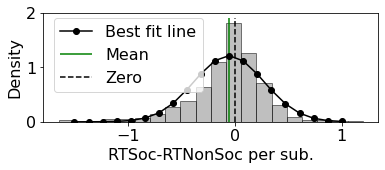

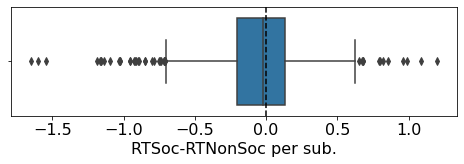

In [107]:
# other optional figure if needed later
plt.figure(1, figsize=(6,2))
data = rts_per_subj['medianYes-medianNo'].values
data  = data[~np.isnan(data)]
_, bins, _ = plt.hist(data, 20, density=1, alpha=0.5,color = 'grey', align = 'mid',edgecolor = 'k')
mu, sigma = scipy.stats.norm.fit(data)
xpts = np.linspace(-1.5,1,20)
best_fit_line = scipy.stats.norm.pdf(xpts, mu, sigma)
plt.plot(xpts, best_fit_line, color = 'k',label = 'Best fit line', marker = 'o')
ymin,ymax = plt.ylim()
plt.vlines(mu,ymin,ymax,color = 'g',label = 'Mean')
plt.vlines(0,ymin,ymax,color = 'k',label = 'Zero',ls = 'dashed')
plt.xlabel('RTSoc-RTNonSoc per sub.')
#plt.xticks([-5,-3,-1,0,1,3,5,7], rotation=30)
plt.ylabel('Density')
plt.legend(bbox_to_anchor = [0.5,0.2])

plt.figure(2, figsize=(8,2))
sns.boxplot(x=data)
ymin,ymax = plt.ylim()
#plt.vlines(mu,ymin,ymax,color = 'g',label = 'Mean')
plt.vlines(0,ymin,ymax,color = 'k',label = 'Zero',ls = 'dashed')
plt.xlabel('RTSoc-RTNonSoc per sub.')


## LMEs

Formula: rt~response+(response|subj_idx)

Family: gaussian	 Inference: parametric

Number of observations: 7756	 Groups: {'subj_idx': 826.0}

Log-likelihood: -4657.663 	 AIC: 9315.326

Random effects:

                 Name    Var    Std
subj_idx  (Intercept)  0.055  0.235
subj_idx     response  0.014  0.118
Residual               0.169  0.411

                  IV1       IV2   Corr
subj_idx  (Intercept)  response -0.687

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE       DF  T-stat  P-val  Sig
(Intercept)     1.025   1.004    1.046  0.011  775.936  96.096    0.0  ***
response       -0.039  -0.059   -0.019  0.010  783.139  -3.789    0.0  ***


Text(0.5, 1.0, 'Residuals from\nrt ~  response +(response|subj_idx)\nnormality test stat=2037.46,p=0.00e+00')

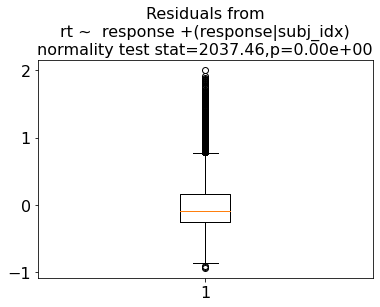

In [109]:
model = Lmer('rt ~  response +(response|subj_idx)', data=data_sure) # ff: mean response, rf:subjID
print(model.fit())
#sns.regplot(x= 'response',y= 'residuals', data= model.data, fit_reg= False)
#plt.hist(model.residuals)
plt.boxplot(model.residuals)
ymin,ymax=plt.ylim()
#plt.vlines(np.nanmean(model.residuals),ymin,ymax,color='k',label=f'mean={np.nanmean(model.residuals):.3f}')
stat,p=stats.normaltest(model.residuals)
plt.title(f'Residuals from\nrt ~  response +(response|subj_idx)\nnormality test stat={stat:.2f},p={p:.2e}')
#plt.legend()

In [110]:
len(np.unique(data_sure['subj_idx']))

826

Formula: logRT~response+(response|subj_idx)

Family: gaussian	 Inference: parametric

Number of observations: 7756	 Groups: {'subj_idx': 826.0}

Log-likelihood: -3914.441 	 AIC: 7828.881

Random effects:

                 Name    Var    Std
subj_idx  (Intercept)  0.052  0.229
subj_idx     response  0.009  0.097
Residual               0.138  0.372

                  IV1       IV2   Corr
subj_idx  (Intercept)  response -0.682

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE       DF  T-stat  P-val  Sig
(Intercept)    -0.079  -0.098   -0.059  0.010  791.653  -7.797  0.000  ***
response       -0.017  -0.035    0.001  0.009  786.305  -1.806  0.071    .


Text(0.5, 1.0, 'Residuals from\nlogRT ~  response +(response|subj_idx)\nnormality test stat=149.15,p=4.1e-33')

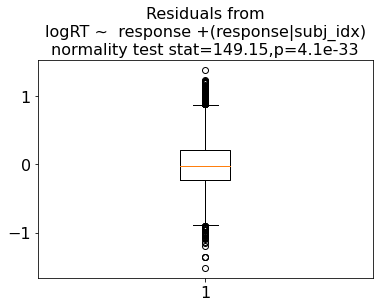

In [111]:
model = Lmer('logRT ~  response +(response|subj_idx)', data=data_sure) # ff: mean response, rf:subjID
print(model.fit())
#sns.regplot(x= 'response',y= 'residuals', data= model.data, fit_reg= False)
plt.boxplot(model.residuals)
stat,p=stats.normaltest(model.residuals)
ymin,ymax=plt.ylim()
#print(np.nanmean(model.residuals))
#plt.vlines(np.nanmean(model.residuals),ymin,ymax,color='k',label=f'mean={np.nanmean(model.residuals):.3f}')
plt.title(f'Residuals from\nlogRT ~  response +(response|subj_idx)\nnormality test stat={stat:.2f},p={p:.1e}')
#plt.legend()


Formula: rt~response+(response|subj_idx)+(1|movie)

Family: gaussian	 Inference: parametric

Number of observations: 7756	 Groups: {'subj_idx': 826.0, 'movie': 10.0}

Log-likelihood: -4010.147 	 AIC: 8020.294

Random effects:

                 Name    Var    Std
subj_idx  (Intercept)  0.063  0.252
subj_idx     response  0.028  0.166
movie     (Intercept)  0.029  0.170
Residual               0.136  0.369

                  IV1       IV2  Corr
subj_idx  (Intercept)  response -0.64

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)     1.032   0.922    1.142  0.056    10.510  18.381  0.000  ***
response       -0.045  -0.096    0.005  0.026  2729.695  -1.762  0.078    .


NormaltestResult(statistic=2126.236486581014, pvalue=0.0)

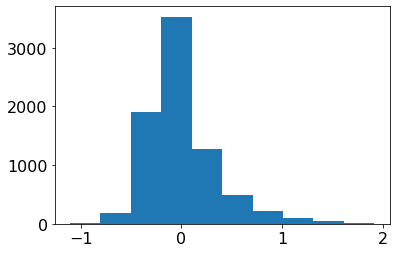

In [112]:
model = Lmer('rt ~  response +(response|subj_idx) + (1|movie)', data=data_sure) # ff: mean response, rf:subjID
print(model.fit())
#sns.regplot(x= 'response',y= 'residuals', data= model.data, fit_reg= False)
plt.hist(model.residuals)
stats.normaltest(model.residuals)

Formula: logRT~response+(response|subj_idx)+(1|movie)

Family: gaussian	 Inference: parametric

Number of observations: 7756	 Groups: {'subj_idx': 826.0, 'movie': 10.0}

Log-likelihood: -3080.848 	 AIC: 6161.695

Random effects:

                 Name    Var    Std
subj_idx  (Intercept)  0.061  0.246
subj_idx     response  0.023  0.152
movie     (Intercept)  0.029  0.172
Residual               0.104  0.323

                  IV1       IV2   Corr
subj_idx  (Intercept)  response -0.612

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val Sig
(Intercept)    -0.064  -0.175    0.046  0.056    10.246  -1.146  0.278    
response       -0.038  -0.083    0.007  0.023  3619.873  -1.654  0.098   .


NormaltestResult(statistic=300.2040135250824, pvalue=6.479279883282508e-66)

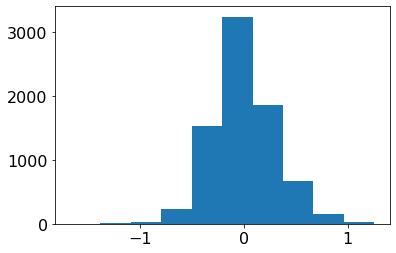

In [113]:
model = Lmer('logRT ~  response +(response|subj_idx) + (1|movie)', data=data_sure) # ff: mean response, rf:subjID
print(model.fit())
#sns.regplot(x= 'response',y= 'residuals', data= model.data, fit_reg= False)
plt.hist(model.residuals)
stats.normaltest(model.residuals)

Model residuals are not normally distributed as shown above - so in the future, need to pick a better family of distribution for RT. Log RT reduces nonnormality a bit but not enough

- model with movie and random effect is generally better - however, we are also treating movies as fixed effects in this paper - so eclude movie as RFX for now..

## 3. Uncertainty analyses

In [114]:
'''thresh = 10
trial_counts = dat.groupby("subj_idx").count()["rt"]
bad_subs = trial_counts[(trial_counts < thresh)].index
#print(bad_subs)
dat  = dat.reset_index() # add index as an additional column "index"
dat = dat.set_index('subj_idx') # make subj_idx the index
dat.drop(bad_subs, inplace=True) # remove bad subjects
dat = dat.reset_index() #bring back subj_idx as a column
dat = dat.set_index('index') # make the column "index" as the index (as in the beginning)

print("Nr. of subjects left",len(dat.groupby("subj_idx")))
print("Nr. of rows:",dat.shape)'''


'thresh = 10\ntrial_counts = dat.groupby("subj_idx").count()["rt"]\nbad_subs = trial_counts[(trial_counts < thresh)].index\n#print(bad_subs)\ndat  = dat.reset_index() # add index as an additional column "index"\ndat = dat.set_index(\'subj_idx\') # make subj_idx the index\ndat.drop(bad_subs, inplace=True) # remove bad subjects\ndat = dat.reset_index() #bring back subj_idx as a column\ndat = dat.set_index(\'index\') # make the column "index" as the index (as in the beginning)\n\nprint("Nr. of subjects left",len(dat.groupby("subj_idx")))\nprint("Nr. of rows:",dat.shape)'

In [115]:
certainty = np.ones(len(dat['response']))
certainty = [1 if i != 9 else 0 for i in dat['response'].values]
dat['certainty'] = certainty
uncertainty = [0 if i != 9 else 1 for i in dat['response'].values]
dat['uncertainty'] = uncertainty

#dat = dat.assign(certainty)
dat.head(10)

,subj_idx,stim,movie,rt,response,run,accuracy,movies_ind,certainty,uncertainty
index,,,,,,,,,,
0,168745,Mental,Scaring.AVI,1.252,1,1,1.0,5,1,0
1,168745,Mental,SEDUCING-B.AVI,0.578,1,1,1.0,6,1,0
2,168745,Random,STAR-A.AVI,1.643,0,1,1.0,7,1,0
3,168745,Mental,SURPRISING-B.AVI,1.082,1,1,1.0,8,1,0
4,168745,Random,TENNIS-A.AVI,1.232,0,1,1.0,9,1,0
5,668361,Mental,COAXING-B.AVI,1.796,9,0,9.0,0,0,1
6,668361,Random,BILLIARD-A.AVI,1.254,0,0,1.0,1,1,0
7,668361,Random,DRIFTING-A.AVI,0.590,0,0,1.0,2,1,0
8,668361,Mental,Fishing.AVI,0.993,0,0,0.0,3,1,0


before: (826, 2)
after: (826, 2)
Mental: 25%:0.00, 50%:0.00, 75%:0.00
Random: 25%:0.00, 50%:0.00, 75%:20.00


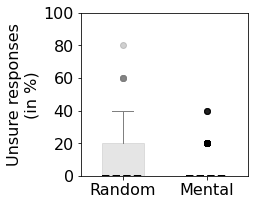

In [140]:
def plot_fig_1e(ax,summary):
    cols = summary.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    summary = summary[cols]
    print('before:',summary.shape)
    summary = summary.loc[(~np.isnan(summary['Random'])&(~np.isnan(summary['Mental']))),:]
    print('after:',summary.shape)
    mn = summary.mean()
    sem = summary.sem()

    bp1 = box_plot(summary['Random'], 'grey', 'grey',0,True)
    bp2 = box_plot(summary['Mental'], 'black', 'black',1,True)
    
    #Figure 1c in the submitted OHBM abstract
    #sns.barplot(data=summary,alpha=.5,edgecolor='k')
    plt.xticks((0,1),('Random','Mental'))
    plt.xlabel('')
    plt.ylabel("Unsure responses\n(in %)")
    plt.ylim(0,100)
    #plt.title('Unsure responses',fontweight='bold')

    print(f"Mental: 25%:{np.quantile(summary['Mental'],.25):.2f}, 50%:{np.quantile(summary['Mental'],.5):.2f}, 75%:{np.quantile(summary['Mental'],.75):.2f}")
    print(f"Random: 25%:{np.quantile(summary['Random'],.25):.2f}, 50%:{np.quantile(summary['Random'],.5):.2f}, 75%:{np.quantile(summary['Random'],.75):.2f}")
    return summary
    
summary = 100*dat.groupby(['subj_idx','stim']).mean().uncertainty.unstack(level=-1)
summary.shape
fig = plt.figure(1,figsize = (3,3))
ax = fig.add_subplot(111)
summary = plot_fig_1e(ax,summary)


In [138]:
summary1 = summary.rename(columns={'Random': 'pc_unc_Rand', 'Mental': 'pc_unc_Mental'})
summary1

stim,pc_unc_Rand,pc_unc_Mental
subj_idx,,
100206,0.0,0.0
100307,0.0,20.0
100408,20.0,0.0
100610,0.0,0.0
101309,60.0,0.0
...,...,...
991267,20.0,0.0
992673,0.0,0.0
992774,20.0,0.0


In [139]:
# save data for trait analysis etc.
summary1.to_csv(os.path.join(file_loc,'data_for_paper','1e_S_NS_pc_uncertainResp_per_subj.csv'))

## Plot all subplots together

In [161]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 24}

matplotlib.rc('font', **font)

In [169]:
import matplotlib.pyplot as plt

SMALL_SIZE = 20
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [176]:
fig_save_loc = '/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/paper_prep/figures/fig1_hcpbeh'

mean diff: 5.602076591154261
27043.0 , 5.418474953624208e-19
before: (826, 2)
after: (826, 2)
Mental: 25%:0.00, 50%:0.00, 75%:0.00
Random: 25%:0.00, 50%:0.00, 75%:20.00


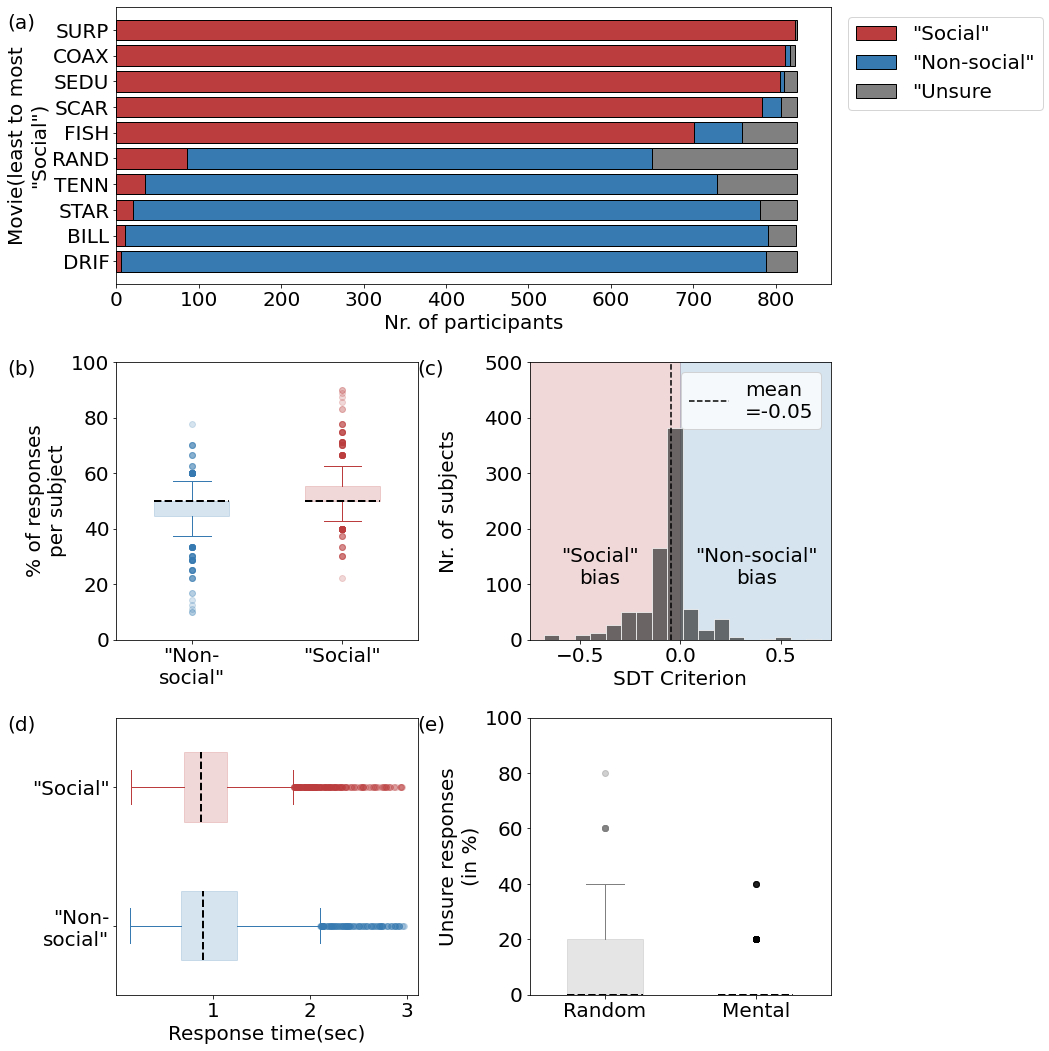

In [195]:
fig = plt.figure(1,figsize = (15,15))
ax = fig.add_subplot(311)
plot_fig_1a(ax)

ax = fig.add_subplot(323)
plot_fig_1b(ax)
#ax.set_ylabel(fontsize = 20)

ax = fig.add_subplot(324)
plot_fig_1c(ax)

ax = fig.add_subplot(325)
plot_fig_1d(ax)

ax = fig.add_subplot(326)
summary = plot_fig_1e(ax,summary)

fig.text(0.02,.96,'(a)',fontsize=20)
fig.text(0.02,.64,'(b)',fontsize=20)
fig.text(0.02,.31,'(d)',fontsize=20)
fig.text(0.4,.64,'(c)',fontsize=20)
fig.text(0.4,.31,'(e)',fontsize=20)
plt.tight_layout()

plt.savefig(os.path.join(fig_save_loc,'Figure1.png'),dpi=300,bbox_inches='tight',facecolor='w')

Text(0, 0.5, 'Unsure responses\n(in percent)')

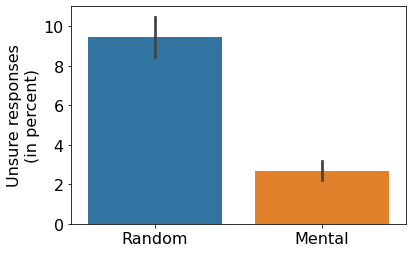

In [129]:
sns.barplot(data=summary.loc[:,['pc_unc_Rand','pc_unc_Mental']].melt(),x='stim',y='value')
     
#Figure 1c in the submitted OHBM abstract
#sns.barplot(data=summary,alpha=.5,edgecolor='k')
plt.xticks((0,1),('Random','Mental'))
plt.xlabel('')
plt.ylabel("Unsure responses\n(in percent)")
#plt.title('Unsure responses',fontweight='bold')


Formula: uncertainty~stim+(stim|subj_idx)

Family: binomial	 Inference: parametric

Number of observations: 8257	 Groups: {'subj_idx': 826.0}

Log-likelihood: -1778.546 	 AIC: 3567.093

Random effects:

                 Name    Var    Std
subj_idx  (Intercept)  0.788  0.888
subj_idx   stimMental  4.339  2.083

                  IV1         IV2   Corr
subj_idx  (Intercept)  stimMental -0.566

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  OR_97.5_ci  \
(Intercept)    -2.567  -2.747   -2.387  0.092  0.077      0.064       0.092   
stim1          -2.151  -2.803   -1.500  0.332  0.116      0.061       0.223   

              Prob  Prob_2.5_ci  Prob_97.5_ci  Z-stat  P-val  Sig  
(Intercept)  0.071        0.060         0.084 -27.959    0.0  ***  
stim1        0.104        0.057         0.182  -6.471    0.0  ***  


(array([ 220., 3918., 3618.,    0.,    0.,    0.,    0.,   47.,  144.,
         310.]),
 array([-0.89468299, -0.56430038, -0.23391777,  0.09646483,  0.42684744,
         0.75723005,  1.08761266,  1.41799527,  1.74837788,  2.07876049,
         2.4091431 ]),
 <BarContainer object of 10 artists>)

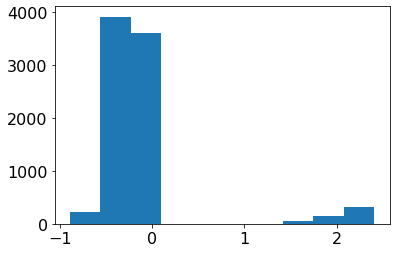

In [130]:
# certainty as a function of stimtype
model = Lmer('uncertainty ~  stim +(stim|subj_idx)', data=dat,family = "binomial") # ff: mean response, rf:subjID
print(model.fit(factors={"stim":["Random","Mental"]}))
#sns.regplot(x= 'response',y= 'residuals', data= model.data, fit_reg= False)
plt.hist(model.residuals)

Formula: uncertainty~stim+(stim|subj_idx)+(1|movie)

Family: binomial	 Inference: parametric

Number of observations: 8257	 Groups: {'subj_idx': 826.0, 'movie': 10.0}

Log-likelihood: -1659.154 	 AIC: 3330.307

Random effects:

                 Name    Var    Std
subj_idx  (Intercept)  0.735  0.857
subj_idx   stimMental  1.495  1.223
movie     (Intercept)  0.747  0.864

                  IV1         IV2   Corr
subj_idx  (Intercept)  stimMental -0.781

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  OR_97.5_ci  \
(Intercept)    -2.764  -3.541   -1.987  0.397  0.063      0.029       0.137   
stim1          -1.572  -2.721   -0.424  0.586  0.208      0.066       0.654   

              Prob  Prob_2.5_ci  Prob_97.5_ci  Z-stat  P-val  Sig  
(Intercept)  0.059        0.028         0.121  -6.968  0.000  ***  
stim1        0.172        0.062         0.396  -2.684  0.007   **  


(array([ 122., 2793., 4841.,    0.,    0.,   47.,  187.,  177.,   81.,
           9.]),
 array([-1.15276953, -0.72419787, -0.29562622,  0.13294544,  0.56151709,
         0.99008875,  1.4186604 ,  1.84723206,  2.27580371,  2.70437537,
         3.13294702]),
 <BarContainer object of 10 artists>)

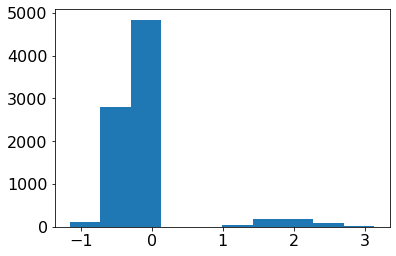

In [555]:
# certainty as a function of stimtype
model = Lmer('uncertainty ~  stim +(stim|subj_idx) + (1|movie)', data=dat,family = "binomial") # ff: mean response, rf:subjID
print(model.fit(factors={"stim":["Random","Mental"]}))
#print(model.fit())
#sns.regplot(x= 'response',y= 'residuals', data= model.data, fit_reg= False)
plt.hist(model.residuals)

# extra analyses

## response counts

In [ ]:
# - So looks like there are movie-specific differences in uncertainty and accuracy - are these correlated?
stats.pearsonr(count_unsure_per_movie.values,acc_per_movie.values)

#- Indeed, looks like there's a negative correlation - i.e., movies with higher uncertainty have lower accuracies - which makes sense
 
#mean responses per subject - if this is above 0.5, it shows a bias for '1' or 'yes' responses

plt.figure(1,figsize =(6,3))
plt.subplot(121)
mean_r = data_sure.groupby(["subj_idx"]).mean().response # pandas series of mean responses per subj
plt.hist(mean_r, bins = 10, alpha = 0.5)
plt.xlabel("Fraction of 'yes' responses")
plt.ylabel("Number of subjects")
ymin,ymax = plt.ylim()
plt.vlines(.5,ymin,ymax, 'k', linestyle = 'dashed', label = '0.5')
plt.vlines(np.mean(mean_r),ymin,ymax, 'r', linestyle = 'dashed', label = 'mean')
plt.ylim(0,450)
plt.tight_layout()
plt.legend()

# another way to test for a social bias: look at the #yes/#no ratio --> if >1 this suggests 
# a yes bias

yes_to_no = counts_per_subj[1]/counts_per_subj[0]

plt.subplot(122)
yes_to_no.hist(bins = 30,alpha = 0.4)
plt.grid(None)
#print(np.unique(yes_to_no))
plt.xlabel("YES/NO ratio")
plt.xticks(range(10))
plt.ylabel("# subs")
plt.plot(np.ones((11,1))*np.mean(yes_to_no), np.arange(0,550,50), 'r', ls = 'dashed',label = 'mean')
#plt.ylim(0,450)
plt.tight_layout()
plt.legend(bbox_to_anchor =[1.01,1])
#print(np.mean(yes_to_no))
stats.wilcoxon(yes_to_no-1)

## accuracy

In [ ]:
### (b) Accuracies social v. nonsocial (OHBM 2021 ABSTRACT FIG 1A)
# compare social and random trial accuracies, exploring df 

accuracy_per_subj = data_sure.groupby(['subj_idx', 'stim']).mean().accuracy # Mean acc. per subject for Mental and Random
cols = accuracy_per_subj.unstack(level = -1)
print(cols,'\n') # subj_idx and stim are indices, so unstack makes stim columns (with the default level value)
print('MEAN ',cols.mean(),'\n') # mean acc across subjects
print('SEM ',cols.sem(),'\n') # sem acc across subjects
#print('COLUMNS', cols.columns) # Mental and random become columns with unstack

plt.figure(1, figsize=(8,3))
plt.subplot(121)
plt.bar(range(2),cols.mean(),color = 'grey')
#plt.plot(0,cols.mean(),cols.sem(), color = 'black', ls = 'none', marker = 'o', markersize = 8)
plt.errorbar(range(2),cols.mean(),cols.sem(), color = 'black', ls = 'none', marker = 'o', markersize = 8)
plt.tight_layout()
plt.xticks((range(2)),('Social','Non-social'), fontsize = 14)
plt.title('Accuracy', fontsize =14, fontweight = 'bold')
plt.ylim(0.9,0.97)

stats.ttest_rel(cols['Mental'],cols['Random'],nan_policy='omit')


responses_per_subj = data_sure.groupby(['subj_idx']).mean().response # Mean acc. per subject for Mental and Random

plt.subplot(122)
plt.bar(1,np.nanmean(responses_per_subj.values),color = 'grey')
#plt.plot(0,cols.mean(),cols.sem(), color = 'black', ls = 'none', marker = 'o', markersize = 8)
plt.errorbar(1,np.nanmean(responses_per_subj.values),stats.sem(responses_per_subj,nan_policy='omit'), color = 'black', ls = 'none', marker = 'o', markersize = 8)
plt.tight_layout()
plt.yticks([0.4,0.5,0.6],['0.4','fr.Yes=\nfr.No','0.6'], fontsize = 14)
plt.title('Responses', fontsize =14, fontweight = 'bold')
plt.ylim(0.4,0.6)
plt.xlim(0,2)
plt.xticks([])

plt.tight_layout()
stats.ttest_1samp(responses_per_subj.values,.5,nan_policy='omit')

- Hence, the yes to no ratio is greater than 1 and significant --> i.e., more yes's than no's overall

## Supplementary analyses: Movie-wise trends - Accuracy per movie  and #unsure responses/movie


([<matplotlib.axis.XTick at 0x7ff60187e390>,
 [Text(0, 0, 'COAX'),
  Text(1, 0, 'FISH'),
  Text(2, 0, 'SEDU'),
  Text(3, 0, 'SURP'),
  Text(4, 0, 'SCAR'),
  Text(5, 0, 'BILL'),
  Text(6, 0, 'DRIF'),
  Text(7, 0, 'RAND'),
  Text(8, 0, 'STAR'),
  Text(9, 0, 'TENN')])

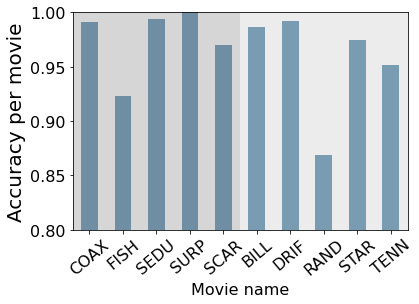

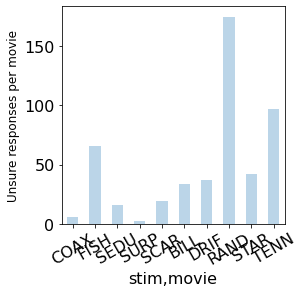

In [62]:
#Accuracy per movie (OHBM ABSTRACT FIG 2A)
acc_per_movie = data_sure.groupby(['stim','movie']).mean().accuracy
#print('acc_per_movie')
#print(acc_per_movie)

# (for the figure axlabels) creating groupwise movie name labels from the variable acc_per_movie
movieNames_grouped = []
for i in range(len(acc_per_movie.index)):
    movieNames_grouped.append(acc_per_movie.index[i][1])
#print('movieNames_grouped:',movieNames_grouped)
lbl = [str.upper(i[0:5]) for i in movieNames_grouped] # first four letters of each movie name

acc_per_movie.plot.bar(color = [0,0.3,0.5], alpha = 0.5)
plt.xlabel("Movie name")
plt.ylabel('Accuracy per movie', fontsize = 20)
lbl = [str.upper(i[0:4]) for i in movieNames_grouped] # first four letters of each movie name
plt.xticks(range(10),lbl, rotation = 40)
plt.axvspan(-0.5,4.5, facecolor='0.2', alpha=0.2) # background color for the first 5 bars(mental?)
plt.axvspan(4.5,10, facecolor='0.3', alpha=0.1) # bgcolor for the next 5 bars (random?)
plt.xlim(-0.5,9.5)
plt.ylim(0.8,1)

plt.figure(2)
#Unsure trials per movie
count_unsure_per_movie = data_unsure.groupby(['stim','movie']).size()
#print('count_unsure_per_movie')
#print(count_unsure_per_movie)

# Plot no. of uncertain responses per movie
count_unsure_per_movie.plot.bar(figsize = (4,4), x ='', y ='', linestyle = 'None', alpha = 0.3)
plt.ylabel('Unsure responses per movie', fontsize = 12)
plt.xticks(range(10),lbl, rotation = 30)



## SDT - extra analyses

In [ ]:
# Distribution of #responses all 4 response types, esp. errors
print(data_sure.groupby(['stim','response']).count())
data_sure.groupby(['stim','response']).count().transpose().loc['accuracy',:].plot.bar()
plt.xticks(range(4),('Miss','Hit','CR','FA'), rotation = 0)
plt.ylabel('Number of responses')
plt.xlabel("")

fig,ax = plt.subplots(figsize = (5,4))
data_sure.groupby(['stim','response']).count().transpose().iloc[1,[0,3]].plot.bar()
plt.xticks(range(2),('Miss','FA'), rotation = 0)
plt.ylabel('Number of responses')
plt.xlabel("")



## LME - extra analysis

In [ ]:
## Response modelling
# model to look for a general bias in responses. The analysis below is a logistic regression,
# so our hypothesis is  if logOR of intercept > 0?
model = Lmer('response ~ (1|subj_idx) + (1|movie)', data=data_sure, family = "binomial") # ff: M/R, prev. trial response, rf:subjID, movie
print(model.fit()) 

### response

In [ ]:
# Next model: response = f(stimulus Type)
model = Lmer('response ~ stim + (1|subj_idx)', data=data_sure, family = "binomial") # ff: M/R, prev. trial response, rf:subjID, movie
print(model.fit(factors={"stim":["Random","Mental"]})) # to make "Random" as the reference intercept term
#print(model.fit())


#Does adding movie improve the model?
model = Lmer('response ~ stim + (1|subj_idx) + (1|movie)', data=data_sure, family = "binomial") # ff: M/R, prev. trial response, rf:subjID, movie
print(model.fit(factors={"stim":["Random","Mental"]})) # to make "Random" as the reference intercept term
#print(model.fit())
 
# adding random slopes for subject
model = Lmer('response ~ stim + (stim|subj_idx) + (1|movie)', data=data_sure, family = "binomial") # ff: M/R, prev. trial response, rf:subjID, movie
print(model.fit(factors={"stim":["Random","Mental"]})) # to make "Random" as the reference intercept term
#print(model.fit())

### RT

In [ ]:
# since RT is quantitative, these analyses are linear regressions
model = Lmer('logRT ~  stim +(stim|subj_idx) + (1|movie)', data=data_sure) # ff: M/R, prev. trial response, rf:subjID, movie
print(model.fit(factors={"stim":["Random","Mental"]})) # to make "Random" as the reference intercept term

# plotting the results
fig,ax = plt.subplots(figsize = (5,5))
sns.violinplot(data=data_sure, x="stim",y="logRT", ax=ax)
ax.axhline(0, linestyle='--')
print(data_sure.groupby("stim").mean().rt)

In [ ]:
# Distribution of all 4 response types, esp. errors

rt_per_respType = data_sure.groupby(['stim','accuracy']).mean().rt
print(rt_per_respType.index)
print(rt_per_respType)
fig,ax = plt.subplots(figsize = (10,4))
#acc_per_movie.plot.bar()
rt_per_respType.plot.bar(figsize = (4,4), alpha = 0.3)
ax.set_ylabel('Mean RT', fontsize = 12)
ax.set_xticks(range(4))
lbl = ['FN','Hit','FP','CR'] # first four letters of each movie name
ax.set_xticklabels(lbl, rotation = 30)

ax.set_xlabel('')

## looks like there's a strong interaction between stim and resp
 
# does the influence of stim and response depend on each other?
model = Lmer('logRT ~  stim*response + (1|subj_idx) + (1|movie)', data=data_sure) # ff: M/R, prev. trial response, rf:subjID, movie
print(model.fit(factors={"stim":["Random","Mental"]}))

# logRT =f(accuracy)
model = Lmer('logRT ~  accuracy +(accuracy|subj_idx) + (1|movie)', data=data_sure) # ff: mean response, rf:subjID
#print(model.fit(factors={"stim":["Random","Mental"]}))
print(model.fit())
#sns.regplot(x= 'response',y= 'residuals', data= model.data, fit_reg= False)
plt.hist(model.residuals)

## uncertainty - extra analyses

In [68]:
n = len(vid_names["run1"])+len(vid_names["run2"])
socialness = np.zeros(len(dat['response']))
for m in range(n):
    rows = np.where(dat["movie"] == stim_mean.index[m])[0]
    socialness[rows] = stim_mean[m]
dat['socialness'] = socialness # add new column
dat.head()

,subj_idx,stim,movie,rt,response,run,accuracy,certainty,uncertainty,socialness
0,168745,Mental,Scaring.AVI,1.252,1,1,1.0,1,0,0.964824
1,168745,Mental,SEDUCING-B.AVI,0.578,1,1,1.0,1,0,0.981057
2,168745,Random,STAR-A.AVI,1.643,0,1,1.0,1,0,0.043433
3,168745,Mental,SURPRISING-B.AVI,1.082,1,1,1.0,1,0,0.983317
4,168745,Random,TENNIS-A.AVI,1.232,0,1,1.0,1,0,0.055879


Formula: certainty~socialness+(socialness|subj_idx)+(1|movie)

Family: binomial	 Inference: parametric

Number of observations: 9948	 Groups: {'subj_idx': 1050.0, 'movie': 10.0}

Log-likelihood: -2119.136 	 AIC: 4250.272

Random effects:

                 Name    Var    Std
subj_idx  (Intercept)  0.976  0.988
subj_idx   socialness  0.766  0.875
movie     (Intercept)  0.577  0.760

                  IV1         IV2  Corr
subj_idx  (Intercept)  socialness -0.54

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE      OR  OR_2.5_ci  OR_97.5_ci  \
(Intercept)     2.646   1.922    3.370  0.370  14.098      6.832      29.092   
socialness      1.467   0.380    2.554  0.554   4.336      1.462      12.854   

              Prob  Prob_2.5_ci  Prob_97.5_ci  Z-stat  P-val  Sig  
(Intercept)  0.934        0.872         0.967   7.159  0.000  ***  
socialness   0.813        0.594         0.928   2.645  0.008   **  


(array([4.000e+01, 1.620e+02, 3.270e+02, 9.500e+01, 1.600e+01, 1.000e+00,
        0.000e+00, 8.035e+03, 1.233e+03, 3.900e+01]),
 array([-2.93294977, -2.50620858, -2.0794674 , -1.65272621, -1.22598502,
        -0.79924384, -0.37250265,  0.05423853,  0.48097972,  0.9077209 ,
         1.33446209]),
 <BarContainer object of 10 artists>)

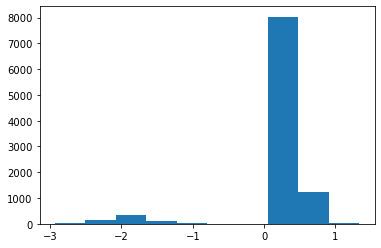

In [141]:
# certainty of responses as a function of perceived socialness
model = Lmer('certainty ~  socialness +(socialness|subj_idx) + (1|movie)', data=dat,family = "binomial") # ff: mean response, rf:subjID
print(model.fit())
#sns.regplot(x= 'response',y= 'residuals', data= model.data, fit_reg= False)
plt.hist(model.residuals)

Formula: certainty~stim+(stim|subj_idx)+(1|movie)

Family: binomial	 Inference: parametric

Number of observations: 9948	 Groups: {'subj_idx': 1050.0, 'movie': 10.0}

Log-likelihood: -2119.181 	 AIC: 4250.363

Random effects:

                 Name    Var    Std
subj_idx  (Intercept)  0.833  0.912
subj_idx   stimRandom  0.626  0.791
movie     (Intercept)  0.560  0.748

                  IV1         IV2   Corr
subj_idx  (Intercept)  stimRandom -0.382

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE      OR  OR_2.5_ci  OR_97.5_ci  \
(Intercept)     4.083   3.371    4.796  0.364  59.336     29.096     121.003   
stimRandom     -1.373  -2.350   -0.396  0.499   0.253      0.095       0.673   

              Prob  Prob_2.5_ci  Prob_97.5_ci  Z-stat  P-val  Sig  
(Intercept)  0.983        0.967         0.992  11.231  0.000  ***  
stimRandom   0.202        0.087         0.402  -2.753  0.006   **  


(array([3.800e+01, 1.340e+02, 2.430e+02, 2.100e+02, 1.500e+01, 1.000e+00,
        0.000e+00, 8.030e+03, 1.238e+03, 3.900e+01]),
 array([-2.93187413, -2.50715138, -2.08242863, -1.65770587, -1.23298312,
        -0.80826037, -0.38353761,  0.04118514,  0.46590789,  0.89063065,
         1.3153534 ]),
 <BarContainer object of 10 artists>)

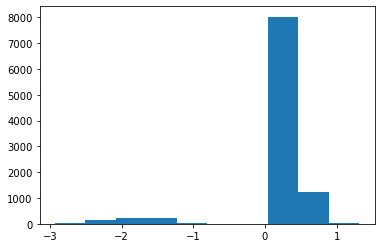

In [144]:
# certainty as a function of stimtype
model = Lmer('certainty ~  stim +(stim|subj_idx) + (1|movie)', data=dat,family = "binomial") # ff: mean response, rf:subjID
#print(model.fit(factors={"stim":["Random","Mental"]}))
print(model.fit())
#sns.regplot(x= 'response',y= 'residuals', data= model.data, fit_reg= False)
plt.hist(model.residuals)

In both the analyses above, the regressors where significant indicating that response certainty can be predicted from binary stimType or continuous (based on general consensus) socialness

In [291]:
# certainty as a function of stimtype
model = Lmer('uncertainty ~  stim +(stim|subj_idx)', data=dat,family = "binomial") # ff: mean response, rf:subjID
print(model.fit(factors={"stim":["Random","Mental"]}))
#print(model.fit())
#sns.regplot(x= 'response',y= 'residuals', data= model.data, fit_reg= False)
#plt.hist(model.residuals)

Formula: uncertainty~stim+(stim|subj_idx)

Family: binomial	 Inference: parametric

Number of observations: 9948	 Groups: {'subj_idx': 1050.0}

Log-likelihood: -2249.163 	 AIC: 4508.326

Random effects:

                 Name    Var    Std
subj_idx  (Intercept)  0.889  0.943
subj_idx   stimMental  2.737  1.654

                  IV1         IV2   Corr
subj_idx  (Intercept)  stimMental -0.349

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  OR_97.5_ci  \
(Intercept)    -2.571  -2.740   -2.402  0.086  0.076      0.065       0.091   
stim1          -1.796  -2.292   -1.300  0.253  0.166      0.101       0.273   

              Prob  Prob_2.5_ci  Prob_97.5_ci  Z-stat  P-val  Sig  
(Intercept)  0.071        0.061         0.083 -29.745    0.0  ***  
stim1        0.142        0.092         0.214  -7.093    0.0  ***  


stim
Mental    0.966444
Random    0.902034
Name: certainty, dtype: float64


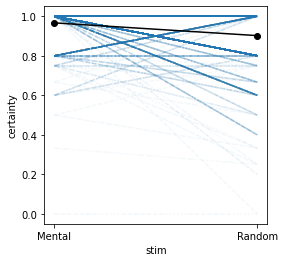

In [148]:
# Alternate version of the last plot showing individual values
fig,ax = plt.subplots(figsize = (4,4))
summary = dat.groupby(['subj_idx','stim']).mean()
print(summary.reset_index().groupby('stim').mean().certainty)
sns.lineplot(data=summary, x="stim", y="certainty", style="subj_idx",legend = False, alpha = 0.05)
plt.plot(summary.reset_index().groupby('stim').mean().certainty, color = 'black', marker = 'o')
#summary.plot(x="stim",y="response", stacked = True)
#ax.set_xticks((0,1))
#ax.set_xticklabels(('No','Yes'), fontsize = 'x-large')
#ax.set_ylabel("RT", fontsize = 'x-large')

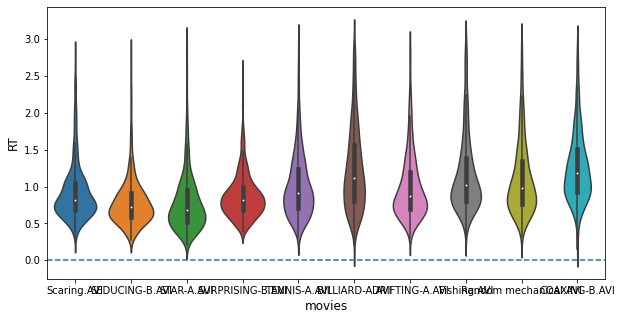

In [161]:
#RT across mean socialness values (or movies)
fig,ax = plt.subplots(figsize = (10,5))
sns.violinplot(x="movie",y="rt",data=data_sure, ax=ax)
ax.set_xticks(range(10))
ax.set_xlabel('movies',fontsize = 12)
ax.set_ylabel('RT',fontsize = 12)
ax.axhline(0, linestyle='--')

# Extra code

<AxesSubplot:xlabel='diff'>

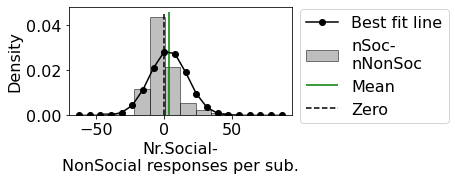

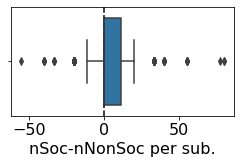

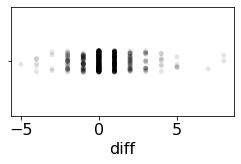

In [249]:
fig = plt.figure(1, figsize=(4,2))

data = counts_per_subj['Soc-NonSoc_pc'].values
_, bins, _ = plt.hist(data, 12, density=1, alpha=0.5,color = 'grey',label = 'nSoc-\nnNonSoc', align = 'mid',edgecolor = 'k')
#plt.hist(data,bins=bins)

mu, sigma = scipy.stats.norm.fit(data)
xmin,xmax = plt.xlim()
x =  np.linspace(xmin,xmax,20)
best_fit_line = scipy.stats.norm.pdf(x, mu, sigma)
plt.plot(x, best_fit_line, color = 'k',label = 'Best fit line', marker = 'o')
ymin,ymax = plt.ylim()
plt.vlines(mu,ymin,ymax,color = 'g',label = 'Mean')
plt.vlines(0,ymin,ymax,color = 'k',label = 'Zero',ls = 'dashed')
plt.xlabel('Nr.Social-\nNonSocial responses per sub.')
#plt.xticks([-5,-3,-1,0,1,3,5,7], rotation=30)
plt.ylabel('Density')
plt.legend(bbox_to_anchor = [1,1.05])

plt.figure(2, figsize=(4,2))

sns.boxplot(x=data)
#sns.boxplot(x="diff", data = cols)
ymin,ymax = plt.ylim()
plt.vlines(0,ymin,ymax,color = 'k',label = 'Zero',ls = 'dashed')
plt.xlabel('nSoc-nNonSoc per sub.')

plt.figure(3, figsize=(4,2))
sns.stripplot(x = "diff", data = counts_per_subj, color = 'k',  alpha = .1)

